In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'grid'])
matplotlib.rcParams["font.size"] = "12"

import torch
import torch.nn as nn
from torch.autograd import grad

from scipy.integrate import solve_ivp

In [ ]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, hidden_layers, hidden_dim, input_dim=1, output_dim=1):
        super(FeedForwardNetwork, self).__init__()
        
        self.L = hidden_layers
        self.W = hidden_dim
        
        self.model = nn.Sequential()
        self.activation = nn.Tanh()
        
        inp_linear = nn.Linear(input_dim, hidden_dim)
        out_linear = nn.Linear(hidden_dim, output_dim)
        
        self.model.add_module('input', inp_linear)
        self.model.add_module('activ0', self.activation)
        for i in range(hidden_layers - 1):
            linear = nn.Linear(hidden_dim, hidden_dim)
            self.model.add_module(f'linear{i+1}', linear)
            self.model.add_module(f'activ{i+1}', self.activation)
        self.model.add_module('output', out_linear)
        
    def forward(self, x):
        return self.model(x)
    
    def weights_norm(self):
        S = 0
        with torch.no_grad():
            for name, parameter in self.model.named_parameters():
                # print(name, torch.linalg.norm(parameter))
                S += torch.linalg.norm(parameter)
        return S.item() / self.L

In [ ]:
class LotkaVolterra:
    def __init__(self, T, params, initial_conditions):
        
        self.T = T
        self.alpha, self.beta, self.delta, self.gamma = params
        self.init_vals = torch.tensor(initial_conditions)

        self.numerical_solution = self._solve()
    
    def loss_initial(self, model):
        zero = torch.tensor([0.], requires_grad=True)
        x = model(zero)
        return torch.mean(torch.square(x - self.init_vals))
    
    def loss_physical(self, model, t):
        xy = model(t)
        x = xy[:,[0]]
        y = xy[:,[1]]

        dX = grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        dY = grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]
        
        loss_dX = torch.mean(torch.square(dX - self.alpha * x + self.beta * x * y))
        loss_dY = torch.mean(torch.square(dY - self.delta * x * y + self.gamma * y))
        
        return loss_dX, loss_dY
    
    def _solve(self):
        def lotka_volterra(t, y, alpha, beta, delta, gamma):
            x, y = y
            dx_dt = alpha * x - beta * x * y
            dy_dt = delta * x * y - gamma * y
            return [dx_dt, dy_dt]

        solution = solve_ivp(lotka_volterra, 
                             (0, self.T),
                             self.init_vals, 
                             method='RK45',
                             args=(self.alpha, self.beta, self.delta, self.gamma), 
                             t_eval=np.linspace(0, self.T, 128))
        
        return solution.y
    
    def plot(self, t, predictions, title, path, figsize=(5, 5), 
    show=True, save=False, dpi=300
    ):
    
        fig = plt.figure(figsize=figsize)
        plt.plot(t, predictions[0], label=r'$\mathcal{X}(t)$')
        plt.plot(t, predictions[1], label=r'$\mathcal{Y}(t)$')
        plt.plot(t, self.numerical_solution[0], label=r'$x(t)$')
        plt.plot(t, self.numerical_solution[1], label=r'$y(t)$')

        plt.xlabel('t')
        plt.ylabel('Population size')

        plt.legend()
        plt.title(title)

        if save:
            plt.savefig(f'{path}/{title}.png', dpi=dpi)

        if show:
            plt.show()
        else:
            plt.close()

In [2]:
def rmse(predicts, target):
    return np.sqrt(np.square(predicts - target).mean())

def train(
    problem,
    model,
    w1, w2, w3, num_iters, N_D, lr,
    collect_every=1000, print_every=1000, save_every=1000
):
    test_points = torch.linspace(0, problem.T, 128).reshape(-1, 1)
    t = torch.linspace(0, problem.T, N_D, requires_grad=True).reshape(-1, 1)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses, errors = [], []

    for i in range(num_iters + 1):

        optimizer.zero_grad()

        L_I = problem.loss_initial(model)
        L_X, L_Y = problem.loss_physical(model, t)

        L = w1 * L_I + w2 * L_X + w3 * L_Y

        L.backward()
        optimizer.step()
        
        if i % print_every == 0:
            preds = model(test_points).detach().numpy()
            x = preds[:,0].flatten()
            y = preds[:,1].flatten()
            
            error_x = rmse(x, problem.numerical_solution[0])
            error_y = rmse(y, problem.numerical_solution[1])
            
            print(f'Iteration {i} --- {error_x}, {error_y}')
        
        if i % collect_every == 0:
            preds = model(test_points).detach().numpy()
            x = preds[:,0].flatten()
            y = preds[:,1].flatten()

            error_x = rmse(x, problem.numerical_solution[0])
            error_y = rmse(y, problem.numerical_solution[1])

            losses.append(np.array([L_I.item(), L_X.item(), L_Y.item(), L.item()]))
            errors.append(np.array([error_x, error_y]))
            
        if i % save_every == 0:
            preds = model(test_points).detach().numpy()
            x = preds[:,0].flatten()
            y = preds[:,1].flatten()
            problem.plot(
                test_points, [x, y], f'Iteration {i}', path='./images/lotkavolterra/training', figsize=(6, 4), show=False, save=True
            )
    
    return np.array(losses), np.array(errors)

In [3]:
model = FeedForwardNetwork(2, 64, input_dim=1, output_dim=2)
problem = LotkaVolterra(25., (0.4, 0.1, 0.1, 0.6), [10., 5.])

w1, w2, w3 = 1, 2, 2
num_iters = 30000
N_D = 1024
lr = 1e-3
collect_every = 500

model.init_weights(torch.nn.init.zeros_)

losses, errors = train(
    problem,
    model,
    w1, w2, w3, num_iters, N_D, lr,
    collect_every=collect_every, print_every=5000, save_every=500
)

c:\Users\dlaptev\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Iteration 0 --- 6.227605098074041, 4.607834769524036
Iteration 5000 --- 1.8556459508703844, 1.5623261874359593
Iteration 10000 --- 0.65960273813146, 0.5524298627989931
Iteration 15000 --- 0.12534422533765419, 0.0867003313098608
Iteration 20000 --- 0.08058428897651623, 0.05100509317323525
Iteration 25000 --- 0.06648013357070015, 0.04257565251901727
Iteration 30000 --- 0.05210578338921661, 0.03236330903097172


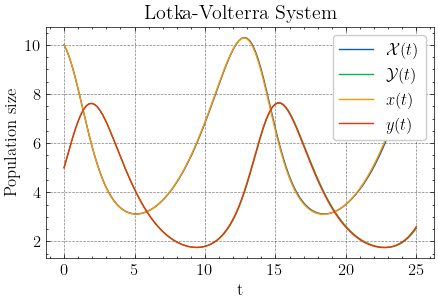

In [4]:
test_points = torch.linspace(0, problem.T, 128).reshape(-1, 1)

preds = model(test_points).detach().numpy()
x = preds[:,0].flatten()
y = preds[:,1].flatten()

problem.plot(
    test_points, [x, y], title='Lotka-Volterra System', figsize=(5, 3), save=True, path='./images/lotkavolterra'
)

In [5]:
from PIL import Image

images = [Image.open(f'./images/lotkavolterra/training/Iteration {i}.png') for i in range(0, num_iters, 500)]
images[0].save(fp="./images/lotkavolterra/Learning.gif", format='GIF', append_images=images[1:], save_all=True, loop=0)

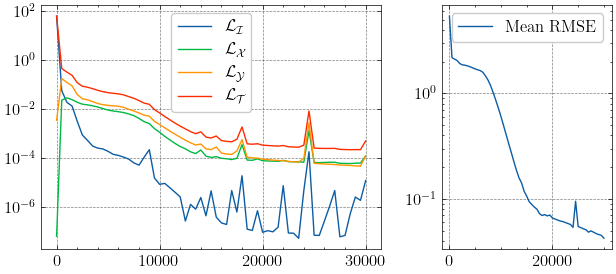

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 3), gridspec_kw={'width_ratios': [2, 1]})

t = np.arange(0, num_iters + 1, 500)

ax[0].plot(t, losses[:,0], label=r'$\mathcal{L_I}$')
ax[0].plot(t, losses[:,1], label=r'$\mathcal{L_X}$')
ax[0].plot(t, losses[:,2], label=r'$\mathcal{L_Y}$')
ax[0].plot(t, losses[:,3], label=r'$\mathcal{L_T}$')

ax[1].plot(t, errors.mean(axis=1), label='Mean RMSE')

ax[0].set_yscale('log')
ax[1].set_yscale('log')

# plt.grid()
ax[0].legend()
ax[1].legend()

plt.tight_layout()

plt.savefig('./images/lotkavolterra/Losses.png', dpi=300)

plt.show()